<b><font size=20, color='#A020F0'>Pysteps

Kaidi Peng, Yichen Tao <br>
11/30/22 <br>

#### <span style="color:green">Learning Goals</span>
By the end of this notebook you will
1. downscaling
2. nowcasting
3. forcasting

#### Resources
[Pysteps Documentation](https://pysteps.readthedocs.io/en/stable/auto_examples/index.html)<br>

The pySTEPS initiative is a community that develops and maintains an easy to use, modular, free and open-source python framework for short-term ensemble prediction systems.

In [180]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

from pysteps import motion
from pysteps.utils import aggregate_fields
from pysteps.downscaling import rainfarm
from pysteps.visualization import plot_precip_field,quiver
from pysteps.nowcasts.lagrangian_probability import forecast
from pysteps.noise.fftgenerators import initialize_nonparam_2d_fft_filter
from pysteps.noise.fftgenerators import generate_noise_2d_fft_filter

## 1. Space Downscaling

Here is the data I created from IMERGV06 Early (https://gpm.nasa.gov/data/imerg), whcih is a near-real-time global satellite precipitation observations. 

Spatial resolution: 0.1 deg; 
lat: 45N - 35N ;
lon: 100S - 85S; 
time: 2018-5-1, with half-hour timestep

We first look at one observation and do space upscaling and downscaling on it.

In [197]:
ds =xr.open_dataset("IMERGE.halfhourly.nc")
imerg=ds.sel(time='2018-05-01T12:00:00.00')

aggregate_fields can aggragate data over space based on the define window size.
window_size is the length of the window that is used to aggregate the fields. Axis defines the Axis or axes to perform the aggregation.

In [198]:
window_size=10  # 10
precip_lr=aggregate_fields(imerg['prcp'].data, window_size, axis=(0,1), method='mean', trim=False)
print(np.shape(precip_lr))  # the size of data reduces accordingly.

(10, 15)


For more interesting application, Pysteps can generate stochastic realizations of the downscaled precipitation field using `rainfarm`. "Stochastic" here means each realization is slightly different.

alpha is spectral slope. We can put None, then the slope is estimated from the input precip. ds_factor is the Downscaling factor. if we use 10 here, the generated precip. will be the same size as our original one.

In [210]:
precip_hr1, alpha1 = rainfarm.downscale(
        precip_lr, ds_factor=10, alpha=None, return_alpha=True)
print(np.shape(precip_hr1)) 

(100, 150)


In [227]:
precip_hr2, alpha2 = rainfarm.downscale(
     precip_lr, ds_factor=10, alpha=alpha1*2, return_alpha=True)
print(np.shape(precip_hr2)) 

(100, 150)


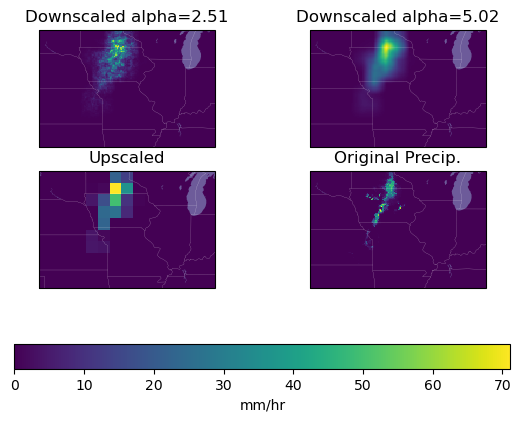

In [228]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
cs=ax1.pcolormesh(ds['longitude'],ds['latitude'],precip_hr1,transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(states_provinces, edgecolor='w',lw=0.1)
ax1.set_title("Downscaled alpha=%0.02f"%(alpha1))

ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
cs=ax2.pcolormesh(ds['longitude'],ds['latitude'],precip_hr2,transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(states_provinces, edgecolor='w',lw=0.1)
ax2.set_title("Downscaled alpha=%0.02f"%(alpha2))

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
cs=ax3.pcolormesh(ds['longitude'][::10],ds['latitude'][::10],precip_lr,transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAKES, alpha=0.5)
ax3.add_feature(states_provinces, edgecolor='w',lw=0.1)
ax3.set_title("Upscaled")

ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
cs=ax4.pcolormesh(ds['longitude'],ds['latitude'],imerg['prcp'].data,transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAKES, alpha=0.5)
ax4.add_feature(states_provinces, edgecolor='w',lw=0.1)
ax4.set_title("Original Precip.")

plt.colorbar(cs,ax=[ax1,ax2,ax3,ax4],location='bottom',label='mm/hr')
plt.show()

Alpha will change how smooth our predicted precip. field be.

## 2. Stochastic Noise Field Generators

The nonparametric approach shown here allows generating perturbation fields with anisotropic structures, but it also requires a larger sample size and is sensitive to the quality of the input data.

In [212]:
precip=np.transpose(ds['prcp'].data,[2,0,1])[-3:,:,:] # (time, lat, lon).

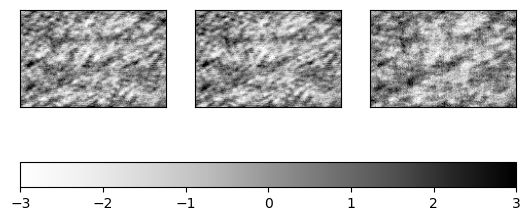

In [214]:
seed = 1
num = 3
Nnp =np.zeros((3,100,150))

for k in range(num):
    Fnp = initialize_nonparam_2d_fft_filter(precip[k,:,:])
    # produces one non-parametric, global and anisotropic fourier filter.
    Nnp[k,:,:]=generate_noise_2d_fft_filter(Fnp, seed=seed)
    #Produces a field of correlated noise using global Fourier filtering.
    
# Plot the generated noise fields
fig, ax = plt.subplots(nrows=1, ncols=3)

# parametric noise
ax[0].imshow(Nnp[0,:,:], cmap=cm.Greys, vmin=-3, vmax=3)
ax[1].imshow(Nnp[1,:,:], cmap=cm.Greys, vmin=-3, vmax=3)
mapp=ax[2].imshow(Nnp[2,:,:], cmap=cm.Greys, vmin=-3, vmax=3)

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
plt.colorbar(mapp,ax=ax,location='bottom')
plt.show()

These noise fields are usually used as perturbation terms in order to represent the uncertainty in the evolution of the rainfall field. For example, a way to create precip. emsembles to present the observations uncertainty involving space-time autocorrelation. (Hartke, S. et al. (2022)https://doi.org/10.1029/2021WR031650).

In [215]:
# scale the noise, add it to precip. 20% random error
precip=precip+precip*Nnp/6

## 3. Precipitation Probability Forcasting

Another magic thing Pysteps can do is forcasting, generaly using optical flow. So we have a look at optical flow at first.

OpenCV implementation of the local Lucas-Kanade optical flow method is applied in combination to a feature detection routine. There are several optical flow calculation menthods covered in pysteps,such as Variational echo tracking, Dynamic and adaptive radar tracking of storms (DARTS), Anisotropic diffusion method. 

The Lucas–Kanade method assumes that the displacement of the image contents between two nearby instants (frames) is small and approximately constant within a neighborhood

For more details about LK optical flow: https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method

In [216]:
oflow_method = motion.get_method("LK")  # 
VLK = oflow_method(precip[-3:,:,:])
print(np.shape(motionV)) #pixels / timestep(30min)

(2, 100, 150)


Pysteps's visualization function `plot_precip_field()` and `quiver()`

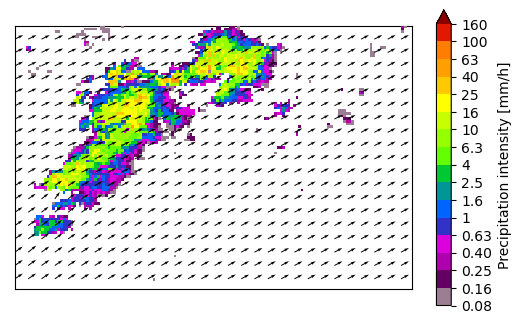

In [217]:
plot_precip_field(precip[-1,:,:])
quiver(VLK,step=5)
plt.show()

This is an example of Variational echo tracking. 

The approach essentially consists of a global optimization routine that seeks at minimizing a cost function between the displaced and the reference image.

In [218]:
oflow_method = motion.get_method("VET")  # 
VVET = oflow_method(precip[-3:,:,:])

Running VET algorithm
original image shape: (3, 100, 150)
padded image shape: (3, 100, 150)
padded template_image image shape: (3, 100, 150)

Number of sectors: 2,2
Sector Shape: (50, 75)
Minimizing

residuals 243927.5492390412
smoothness_penalty 0.0
original image shape: (3, 100, 150)
padded image shape: (3, 100, 152)
padded template_image image shape: (3, 100, 152)

Number of sectors: 4,4
Sector Shape: (25, 38)
Minimizing

residuals 243500.2849417796
smoothness_penalty 0.30371084928661246
original image shape: (3, 100, 150)
padded image shape: (3, 112, 160)
padded template_image image shape: (3, 112, 160)

Number of sectors: 16,16
Sector Shape: (7, 10)
Minimizing

residuals 244495.62575784652
smoothness_penalty 152.18438558363107
original image shape: (3, 100, 150)
padded image shape: (3, 128, 160)
padded template_image image shape: (3, 128, 160)

Number of sectors: 32,32
Sector Shape: (4, 5)
Minimizing

residuals 246066.59530515107
smoothness_penalty 101.471633801768


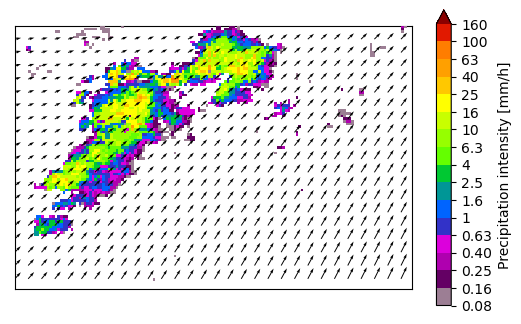

In [219]:
plot_precip_field(precip[-1,:,:])
quiver(VVET,step=5)
plt.show()

motion [0, :, :] contains the x-components of the motion vectors and [1, :, :] contains the y-components. The velocities are in units of pixels / timestep, where timestep is the time difference between the two input images. 

Based on the dense flow, we can do focasting! 

probability forecast: The ouput is the probability of exceeding a given intensity threshold, i.e. P(precip>=threshold). The method is based on the local Lagrangian approach described in Germann and Zawadzki (2004).

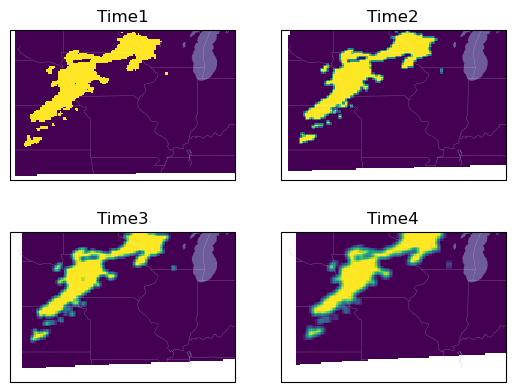

In [229]:
nleadtimes = 4 #
# Number of time steps to forecast 
# or a sorted list of time steps for which the forecasts are computed 

thr = 1  # mm / h  the unit of our original precip. data is mm/hr 
# Intensity threshold for which the exceedance probabilities are computed.

slope = 1 # 0.1 deg/ 30 min
# the unit is in in pixels / timestep
# The slope of the relationship between optimum scale and lead time in pixels / timestep. 
# optimal slope is 1 km / minute (previous study).

# compute probability forecast
extrap_kwargs = dict(allow_nonfinite_values=True)
fct = forecast(
    precip[-1,:,:], VVET, nleadtimes, thr, slope=slope, extrap_kwargs=extrap_kwargs)

# plot
fig = plt.figure()
for n in range(4):
    ax = fig.add_subplot(2, 2, n+1, projection=ccrs.PlateCarree())
    cs=ax.pcolormesh(ds['longitude'],ds['latitude'],fct[n],transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(states_provinces, edgecolor='w',lw=0.1)
    ax.set_title("Time%d"%(n+1))
plt.show()